# Autoencoder-based phenotype derivation v2
- A different autoencoder that takes an image larger than 32 x 32
- Use VOTj left-aligned (probably; check on nepari later) images
- 

In [28]:
# Required libraries
import os
import math
import pims
import bioformats
from natsort import natsorted
import torch
import torchvision
import random
import numpy as np
import pandas as pd
import skimage as ski
from PIL import Image as PILImage
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt
# from aicsimageio import AICSImage
from torchvision.io import read_image
from torchvision.utils import save_image
from torchvision.transforms import v2 as transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
torch.manual_seed(1)

In [4]:
print(torch.version.cuda)

12.1


#### Normalize each image of the VOTj results (votj_aligned_images_align_any) between [0, 255] and output

In [24]:
# Custom min-max scaling function to pass into Compose; transforms pixel values to range [0,255] for each image individually
class MinMaxScaling:
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min()) * 255

In [5]:
transform = transforms.Compose([
    # transforms.ToImage(), # Convert to PIL image
    transforms.ToDtype(torch.float32, scale=True), # Convert to float32; use instead of deprecated ToTensor()
    MinMaxScaling()
])

In [10]:
# within-image normalization
normalized_votj_dir = '/nfs/research/birney/users/esther/medaka-img/votj_aligned_images_align_any_within_normalized/'
if not os.path.exists(normalized_votj_dir):
    os.makedirs(normalized_votj_dir)

list_files = os.listdir(path = '/nfs/research/birney/users/esther/medaka-img/votj_aligned_images_align_any/')
print(len(list_files))

for file in natsorted(list_files):
    if file.endswith('.tif'):
        image = ski.io.imread('/nfs/research/birney/users/esther/medaka-img/votj_aligned_images_align_any/' + file)
        image_normalized = transform(image)
        ski.io.imsave(normalized_votj_dir + '/' + file, image_normalized)
    else:
        print('File ' + file + ' is not a .tif file')
        continue

2353


#### Normalize across the entirety of the VOTj results (votj_aligned_images_align_any) and output

In [ ]:
# Get mean, stdev
import os
import numpy as np
from PIL import Image

imgs_path = '/nfs/research/birney/users/esther/medaka-img/votj_aligned_images_align_any'
img_files = [os.path.join(imgs_path, img) for img in os.listdir(imgs_path) if img.endswith('.tif')]

rgb_values = np.concatenate(
    [Image.open(img).getdata() for img in img_files], 
    axis=0
) / 255

mean_rgb = np.mean(rgb_values, axis=0)  # mean_rgb.shape == (3,)
std_rgb = np.std(rgb_values, axis=0)  # std_rgb.shape == (3,)

print(mean_rgb)
print(std_rgb)

In [ ]:
transform = transforms.Compose([
    # transforms.ToImage(), # Convert to PIL image
    transforms.ToDtype(torch.float32, scale=True), # Convert to float32; use instead of deprecated ToTensor()
    transforms.Normalize((mean_rgb),(std_rgb))
])

In [ ]:
# whole dataset normalization
normalized_votj_dir = '/nfs/research/birney/users/esther/medaka-img/votj_aligned_images_align_any_wholedata_normalized/'
if not os.path.exists(normalized_votj_dir):
    os.makedirs(normalized_votj_dir)

list_files = os.listdir(path = '/nfs/research/birney/users/esther/medaka-img/votj_aligned_images_align_any/')
print(len(list_files))

for file in natsorted(list_files):
    if file.endswith('.tif'):
        image = ski.io.imread('/nfs/research/birney/users/esther/medaka-img/votj_aligned_images_align_any/' + file)
        image_normalized = transform(image)
        ski.io.imsave(normalized_votj_dir + '/' + file, image_normalized)
    else:
        print('File ' + file + ' is not a .tif file')
        continue

### Implement a vanilla autoencoder model from pythae

In [6]:
# Try vanilla CELEBA resnet model
# input_dim = (3, 64, 64)
# latent_dim = 16

from pythae.models import AE, AEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.celeba import Encoder_ResNet_AE_CELEBA, Decoder_ResNet_AE_CELEBA

In [7]:
model_config = AEConfig(
    input_dim=(3, 64, 64),
    latent_dim=16
)

model = AE(
    model_config=model_config,
    encoder=Encoder_ResNet_AE_CELEBA(model_config), 
    decoder=Decoder_ResNet_AE_CELEBA(model_config) 
)

In [99]:
ae_transform = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), # Convert to float32; use instead of deprecated ToTensor()
    MinMaxScaling(),
    transforms.ToImage(), # Convert to PIL image
    transforms.Resize(size = (64,64))
])

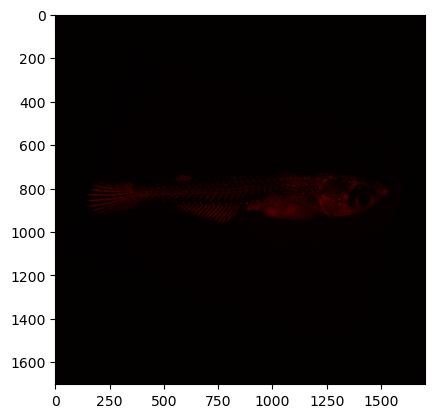

(1702, 1702, 3)


In [78]:
test_img = '/nfs/research/birney/users/esther/medaka-img/votj_aligned_images_align_any/PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01.tif-aligned.tif'

img = ski.io.imread(test_img)
plt.imshow(img)
plt.show()

print(img.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 64, 3])


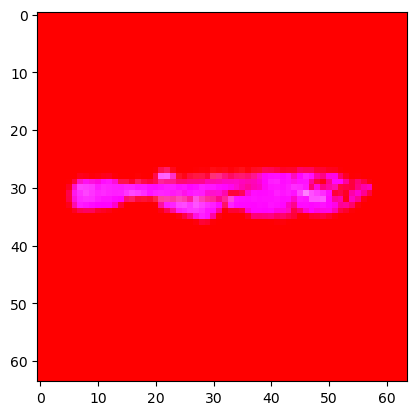

In [100]:
# transform(PILImage.fromarray(img)).unsqueeze(0)

# plt.imshow(PILImage.fromarray(transform(img)).unsqueeze(0))
plt.imshow(np.transpose(ae_transform(img).squeeze(0), (1, 2, 0)))

print(np.transpose(ae_transform(img).squeeze(0), (1, 2, 0)).shape)

In [106]:
print(ae_transform(img).max())
print(ae_transform(img).min())

tensor(98.9498, dtype=torch.float64)
tensor(0., dtype=torch.float64)


In [114]:
feature = model.encoder(torch.rand(1, 3, 64, 64))

In [ ]:
feature_matrix = []
counter = 0

vanilla_ae_input_path = '/nfs/research/birney/users/esther/medaka-img/votj_aligned_images_align_any'

for img_name in natsorted(os.listdir(path = vanilla_ae_input_path)):
    counter += 1
    img = ski.io.imread(vanilla_ae_input_path + "/" + img_name)
    input_img = ae_transform(img).float().squeeze(0)
    feature = model.encoder(input_img.unsqueeze(0)) # model.encoder needs dimension (1, 3, 64, 64)

    feature_matrix.append(feature[0].detach())
    if counter % 10 == 0:
        print(counter)

In [120]:
torch.save(feature_matrix, ('/nfs/research/birney/users/esther/medaka-img/features/pythae_ResNet_AE_vanilla_CELEBA_05092024.pt'))